In [1]:
%matplotlib inline
import os
import cv2
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from skimage.color import rgb2lab, deltaE_cie76

In [2]:
data_path = "Data/"

In [3]:
# HYPERPARAMETERS
image_thresholds = { # Colour Difference Threshold for image type [Left Field, Right Field]
    "ndre": [15, 15],
    "ndvi": [22.5, 22.5],
    "ccci": [50, 60],
    "msavi": [60, 60]
}

K = 3 # No. Neighbours for KNN Dominant Colour Finder

In [4]:
def show_colour(col):
    """
    Plot 100x100x3 image of colour
    
    Inputs
    col: 1x3 rgb values as list
    """
    x = np.ones((100, 100, 3), dtype="uint8")
    x[:, :, :] = col
    fig = plt.figure(figsize = (1,1))
    plt.axis("off")
    plt.imshow(x)

In [5]:
def convertToRGB(im_array):
    """
    Convert MxN to MxNx3 using normalisation + colour mapping
    
    Inputs
    im_array: MxN image as np.array
    
    Return
    MxNx3 rgb image as np.array 
    """
    minima = np.min(im_array)
    maxima = np.max(im_array)
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm)
    rgb = mapper.to_rgba(im_array)[:,:,:3]
    
    return np.multiply(rgb, 255).astype("uint8")

In [6]:
def get_mean_colour(img):
    """
    Retrives the mean colour of the image (NOT USED)
    
    Inputs
    img: MxNx3 image as np.array
    
    Return
    1x3 rgb values as list
    """
    # Ignore bg
    bg = [0, 0, 0]
    
    # Flatten
    img_flat = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    average_color = [img[:, :, i].mean() for i in range(img.shape[-1])]
    count = 0
    redB = 0
    greenB = 0
    blueB = 0
    for pixel in img_flat:
        if not np.array_equal(pixel, bg):
            redB += pixel[0]
            greenB += pixel[1]
            blueB += pixel[2]
            count += 1
    return [redB//count, greenB//count, blueB//count]

In [7]:
def get_dominant_colours(img, K):
    """
    Get K dominant colours in img using KMeans clustering
    
    Input
    img: MxNx3 image as np.array
    K: Number of clusters
    
    Return
    res2: MxNx3 image which consists only of the K dominant colours
    center: List of top K dominant colours (Kx3) 
    """
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2, center

In [8]:
def get_similar(img, colour, threshold):
    """
    Find colour similarity of every pixel in img to specified "colour". Non similar colours are shown as RED
    
    Input
    img: MxNx3 image as np.array
    colour: Specified colour for comparison
    threshold: Threshold between similar and non similar colours
    
    Return
    img: MxNx3 image with non-similar colours as RED as np.array
    """
    lab = rgb2lab(img)
    
    colour_3d = np.uint8(np.asarray([[colour]]))
    red_3d = np.uint8(np.asarray([[255, 0, 0]]))
    
    dE = deltaE_cie76(rgb2lab(colour_3d), lab)
    
    img_flat = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    notBlack = np.array([not np.array_equal(item, [0,0,0]) for item in img_flat]).reshape(img.shape[:2])
    
    img[np.multiply(dE >= threshold, notBlack)] = red_3d
    
    return img

In [9]:
def get_similar_bg(img, bg_colour, threshold):
    """
    Find colour similarity of every pixel in img to specified "colour". Similar colours are shown as BLACK (ie, black background)
    
    Input
    img: MxNx3 image as np.array
    colour: Specified colour for comparison
    threshold: Threshold between similar and non similar colours
    
    Return
    img: MxNx3 image with similar colours as BLACK as np.array
    """
    lab = rgb2lab(img)
    
    colour_3d = np.uint8(np.asarray([[bg_colour]]))
    black_3d = np.uint8(np.asarray([[0, 0, 0]]))
    
    dE = deltaE_cie76(rgb2lab(colour_3d), lab)
    
    img_flat = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    notBlack = np.array([not np.array_equal(item, [0,0,0]) for item in img_flat]).reshape(img.shape[:2])
    
    img[dE < threshold] = black_3d
    
    return img

In [10]:
def rgb_to_rgba(img):
    """
    Convert rgb image to rgba PIL image
    
    Input
    img: MxNx3 image as np.array
    
    Return
    im: MxNx4 image as PIL object
    """
    im = Image.fromarray(img).convert("RGBA")
    datas = im.getdata()
    newData = []
    for item in datas:
        if item[0] == 0 and item[1] == 0 and item[2] == 0:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)

    im.putdata(newData)
    return im

In [11]:
def export_results(outfile, results):
    """Save results as png to outfile"""
    for i, result in enumerate(results):
        im = rgb_to_rgba(result)
        im.save(outfile + im_list_tif[i][:-3] + "png", "PNG")

The next few lines of code are just to demonstrate with images what the process is like for a sample image.

Steps are as followed:
### 1. Load Image
### 2. Segment the Image
### 3. Find a reference colour for each segment
### 4. Filter out outliers
### 5. Merge the segments together

## 1. Load Image
Images are saved in Data directory. We will load all the .tif files. Images are converted into MxN arrays, which then need to be converted to MxNx3 RGB arrays. Some cleaning is done to make the background black.

In [12]:
# Extract Images from data_path
im_list_tif = [item for item in os.listdir(data_path) if item[-3:] == "tif"]

In [13]:
# Open example
im = Image.open(data_path + im_list_tif[3])
im_array = np.array(im)

In [14]:
# Convert to RGB array
img = convertToRGB(im_array)

In [15]:
# Convert purple background to black
img = get_similar_bg(img, [68, 1, 84], 5)

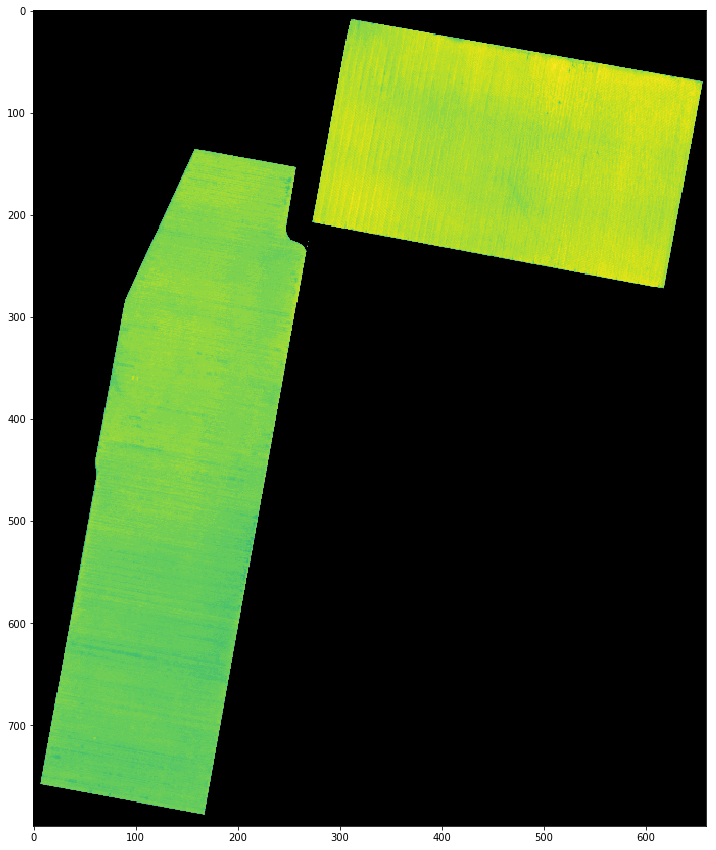

In [16]:
fig = plt.figure(figsize=(15,15))
plt.imshow(img)

## 2. Segment the Image
The image clearly has two fields. The task is to determine irregularities in colour in the fields. Clearly the left field is more "green," while the right field is more "yellow," so I decided to analyse each field as separate entities. 

To segment the Image, I sliced through the middle of the picture, and saved the left field in img_1, and the right in img_2.

In [17]:
# Segment the Image
img_1 = np.zeros(img.shape, dtype="uint8")
img_2 = np.zeros(img.shape, dtype="uint8")
img_1[:, :273, :] = img[:, :273, :]
img_2[:, 273:, :] = img[:, 273:, :]

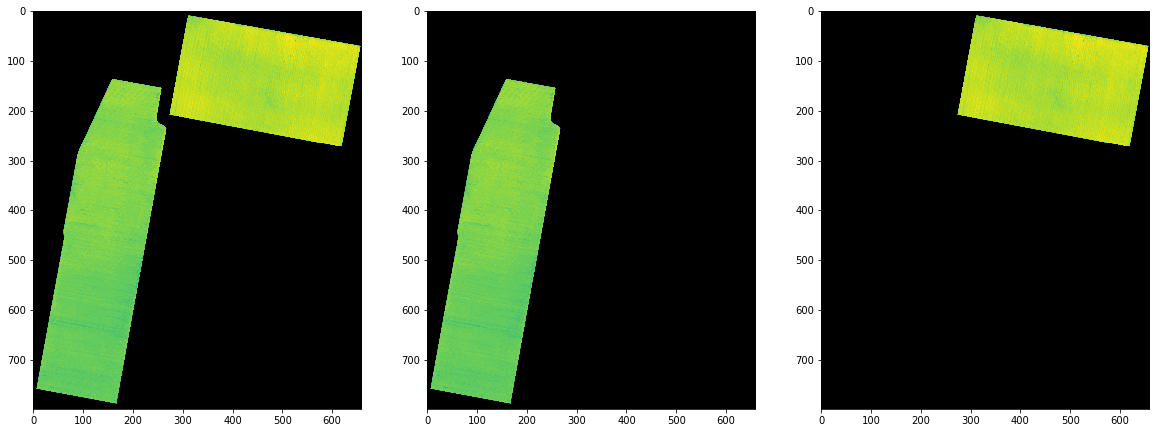

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20,15))
ax[0].imshow(img)
ax[1].imshow(img_1)
ax[2].imshow(img_2)

## 3. Find a reference colour for each segment
In order to find irregularities, we need to determine what is "normal." Methods include extracting the mean, medium, or mode for the reference colour in each field. With the assumption that irregularities are typically darker patches, I wanted to get a colour which is more pale than the mean. 

I used KMeans clustering with K centers (colours) to get the top K dominant colours for each field, and extracted the lightest colour from the list to use as my reference colour. 

In [19]:
# Get top 5 dominant colours for each field
_, dom_colours_1 = get_dominant_colours(img_1, 5)
_, dom_colours_2 = get_dominant_colours(img_2, 5)

In [20]:
# Extract the lightest colour from the list
mean_colour_1 = dom_colours_1[np.argmax(np.sum(dom_colours_1, axis=1))]
mean_colour_2 = dom_colours_2[np.argmax(np.sum(dom_colours_2, axis=1))]

## 4. Filter out outliers
Now that we have our reference colour, it is time to find the irregularities. I used the inbuilt CIE76 colour difference formula to find the degree of similarity between the reference colour and the fields. The irregular spots are highlighted as RED in the new image. 

In [21]:
# Filter out outliers, and show them as red in the new image
new_img_1 = get_similar(np.copy(img_1), mean_colour_1, 25)
new_img_2 = get_similar(np.copy(img_2), mean_colour_2, 25)

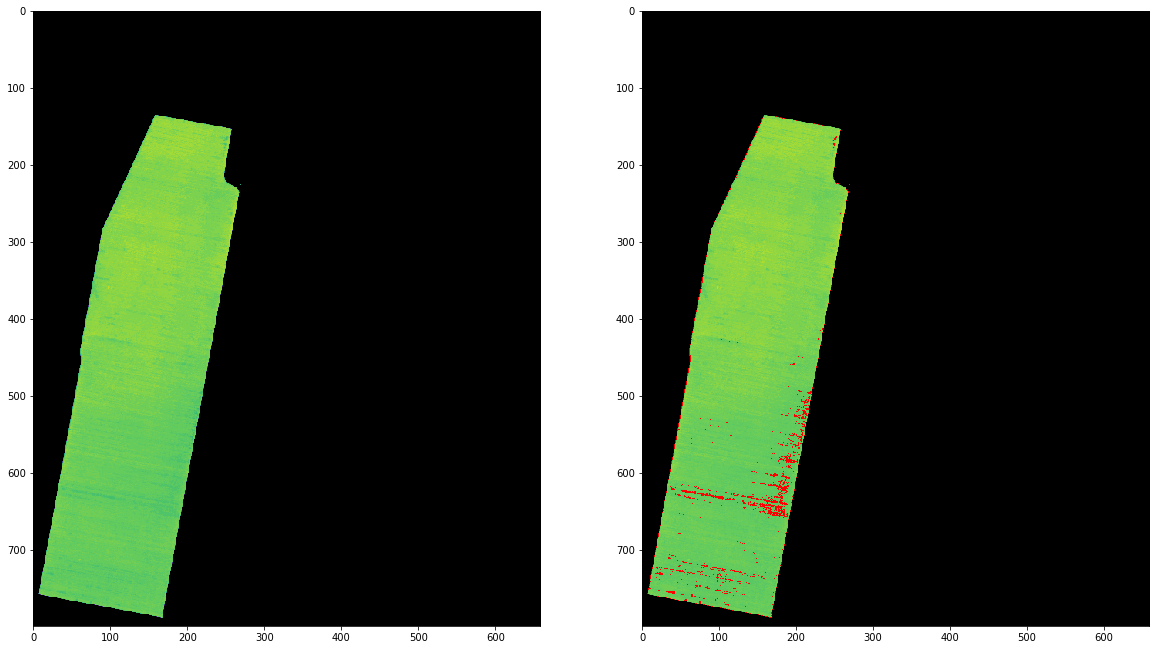

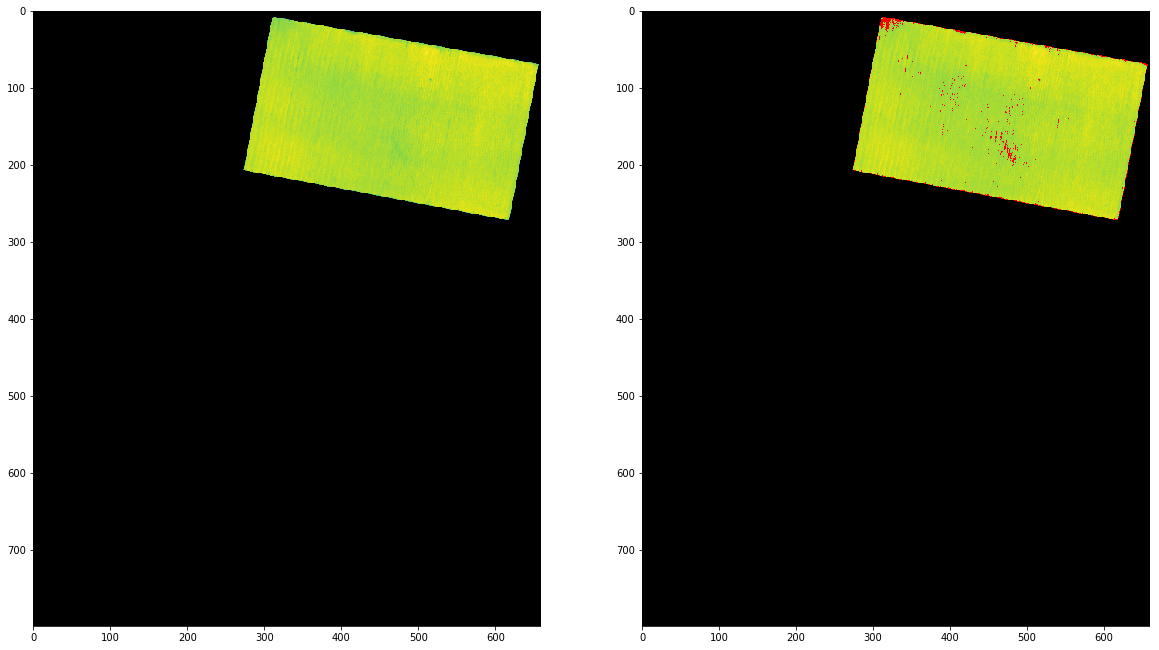

In [22]:
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(img_1)
ax[1].imshow(new_img_1)
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(img_2)
ax[1].imshow(new_img_2)

## 5. Merge the segments together
To get the final result, we need to put the images back together again. Since the background is black (0, 0, 0), we can simply just add the pictures together. I showed the final image with the original image as reference. 

In [23]:
# Combine both images to get the final result
result = cv2.add(new_img_1, new_img_2)

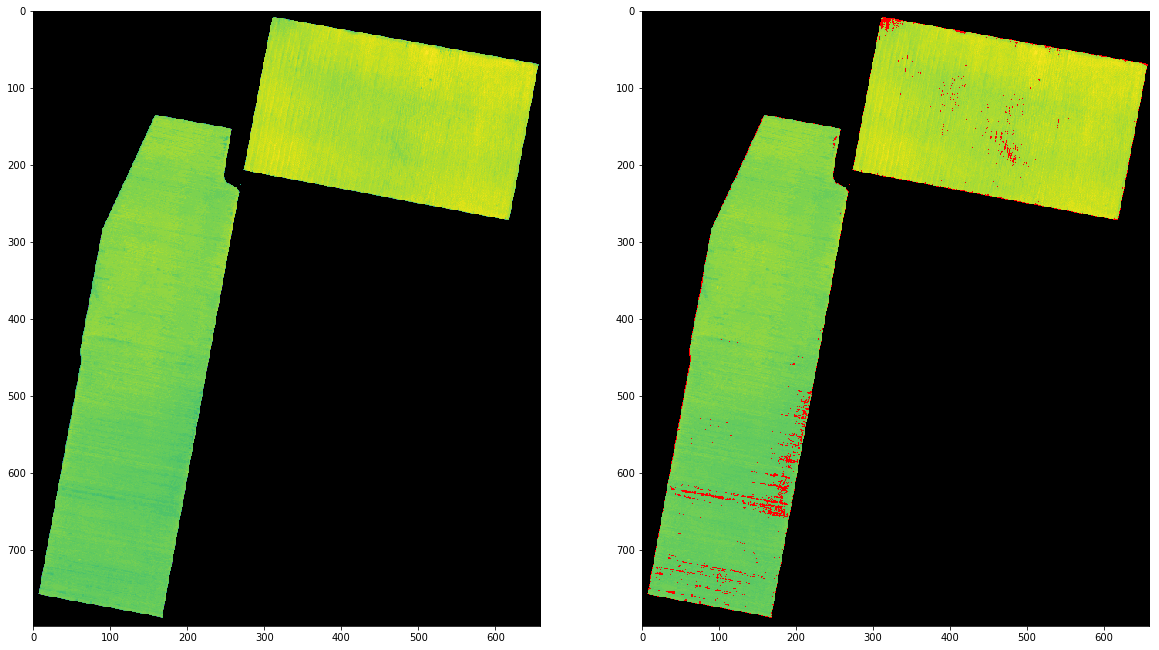

In [24]:
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(img)
ax[1].imshow(result)

Below is the code to process multiple images and save them in the "Results" folder

In [25]:
im_list_tif = [item for item in os.listdir(data_path) if item[-3:] == "tif"]

20171212T000000_HIRAMS_PLN_ccci_gray.tif


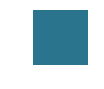

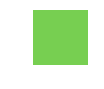

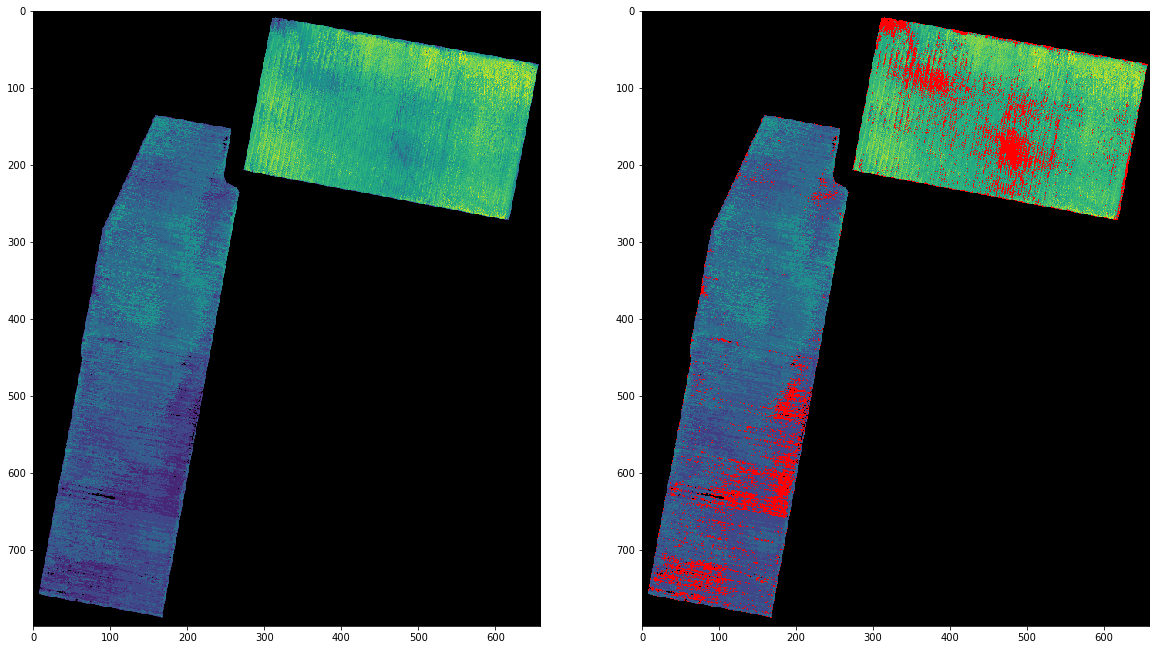

20171212T000000_HIRAMS_PLN_msavi_gray.tif


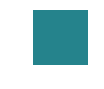

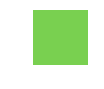

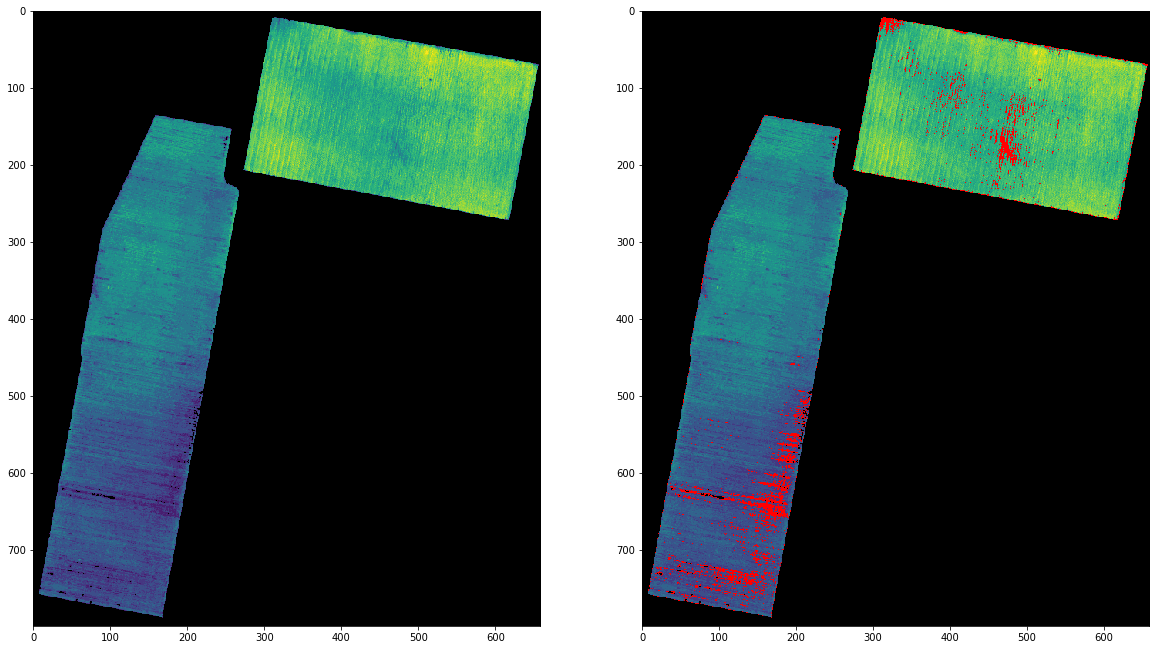

20171212T000000_HIRAMS_PLN_ndre_gray.tif


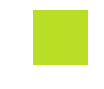

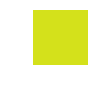

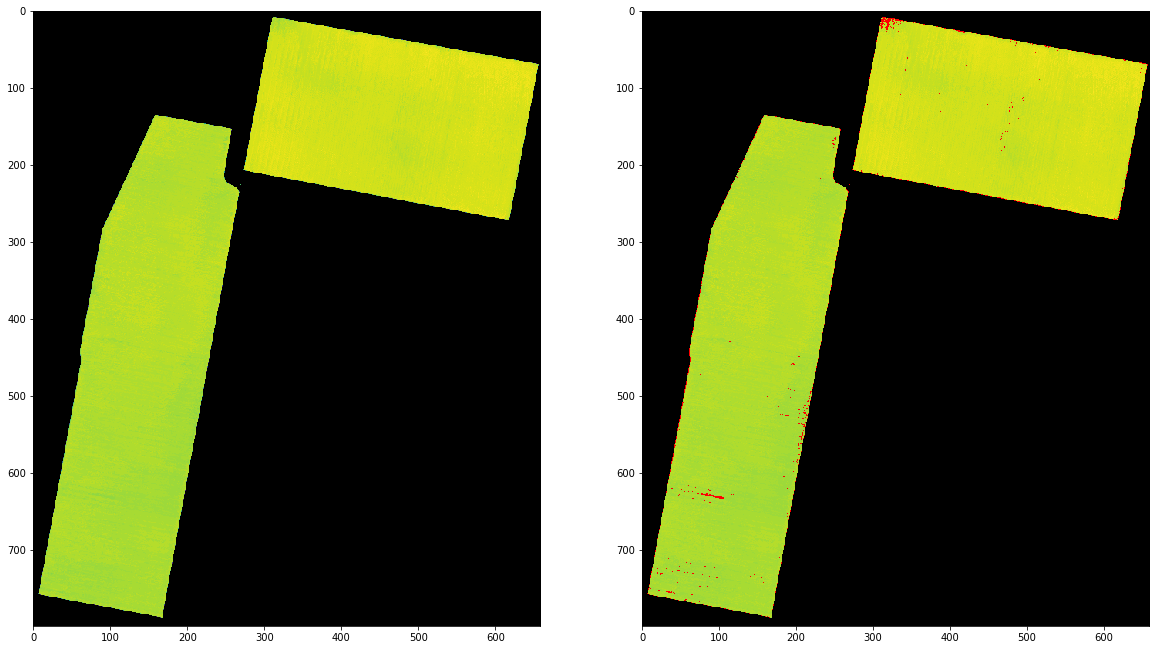

20171212T000000_HIRAMS_PLN_ndvi_gray.tif


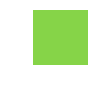

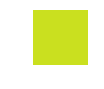

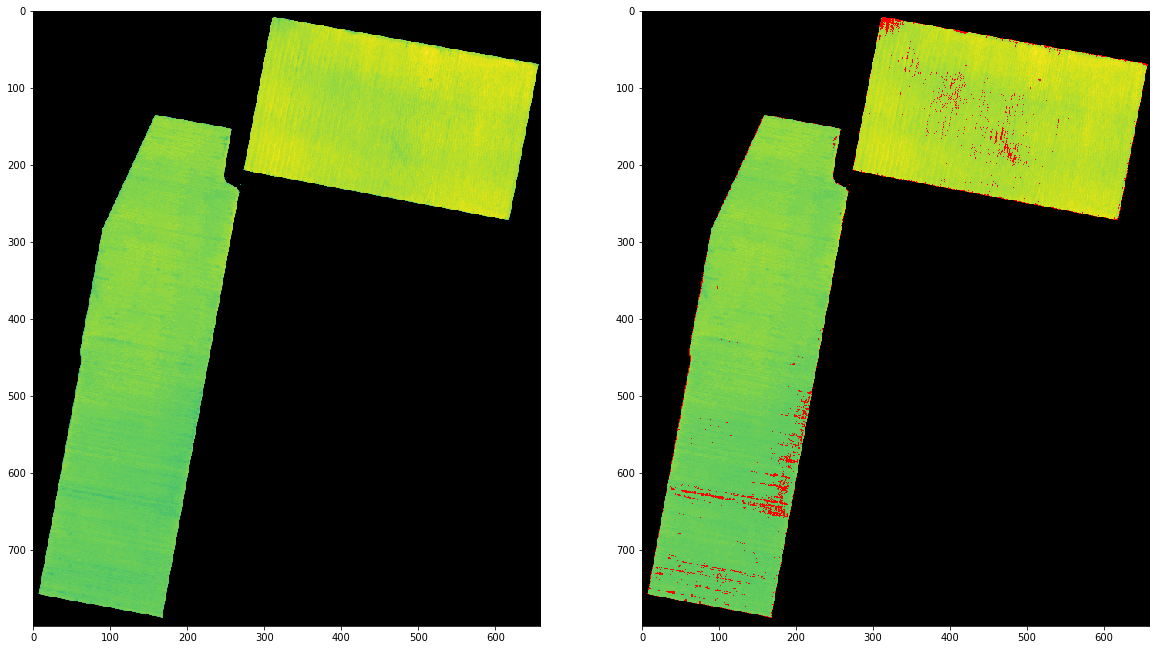

20171219T000000_HIRAMS_PLN_ccci_gray.tif


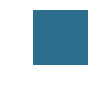

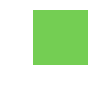

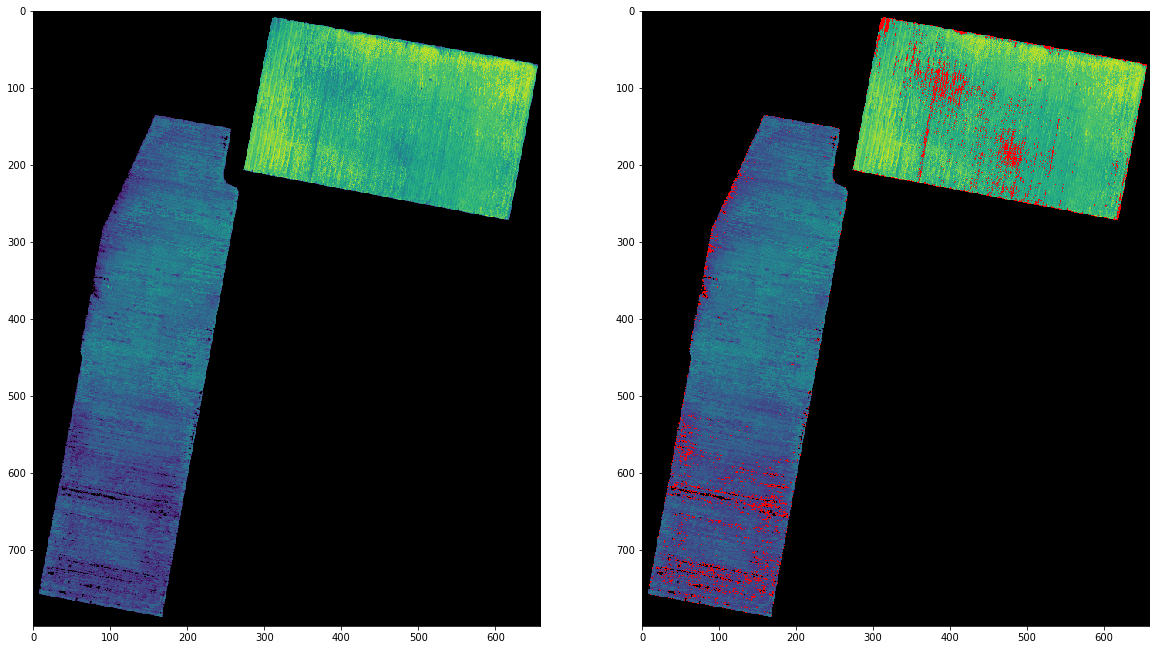

20171219T000000_HIRAMS_PLN_msavi_gray.tif


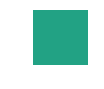

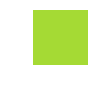

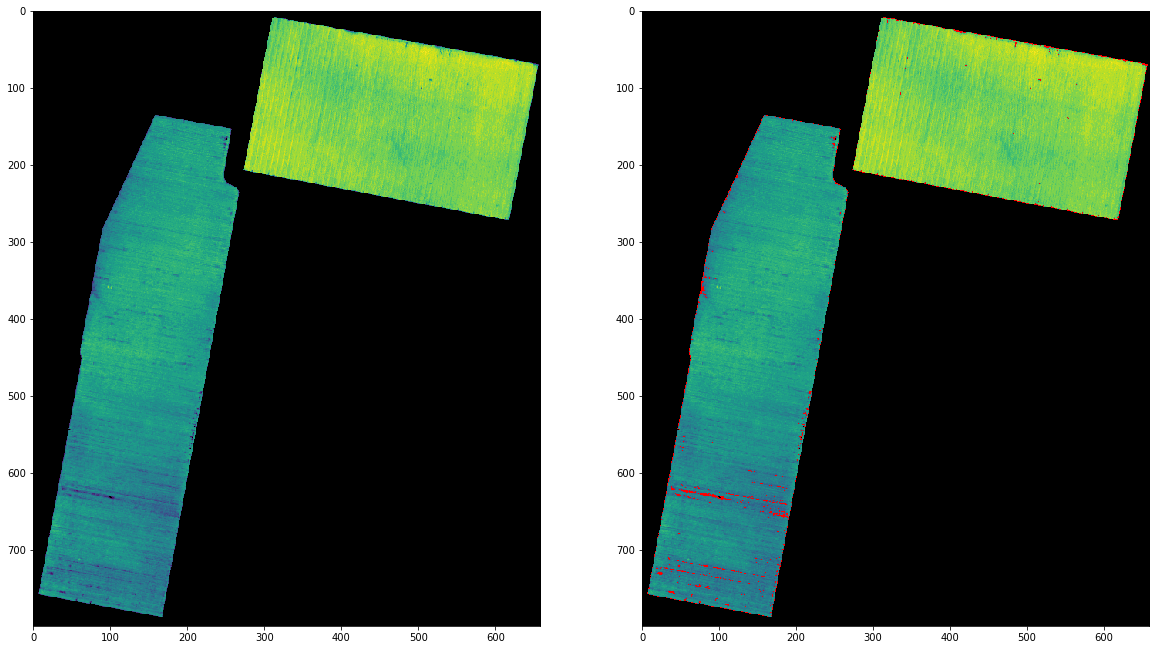

20171219T000000_HIRAMS_PLN_ndre_gray.tif


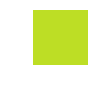

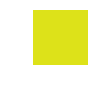

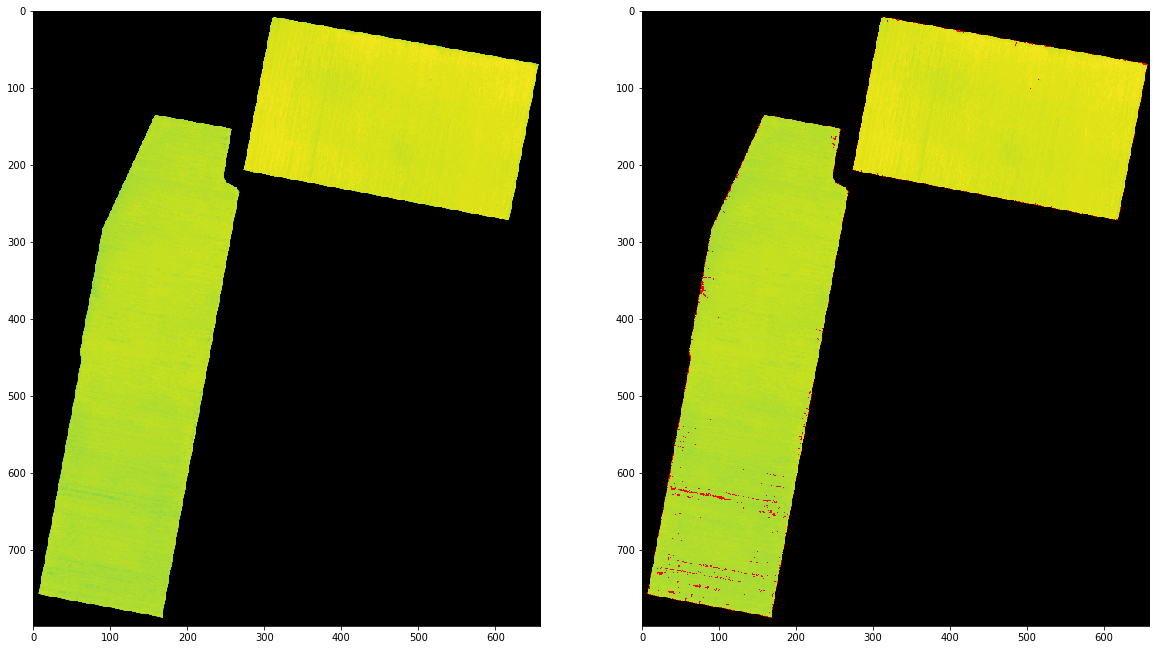

20171219T000000_HIRAMS_PLN_ndvi_gray.tif


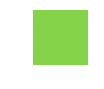

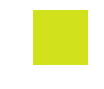

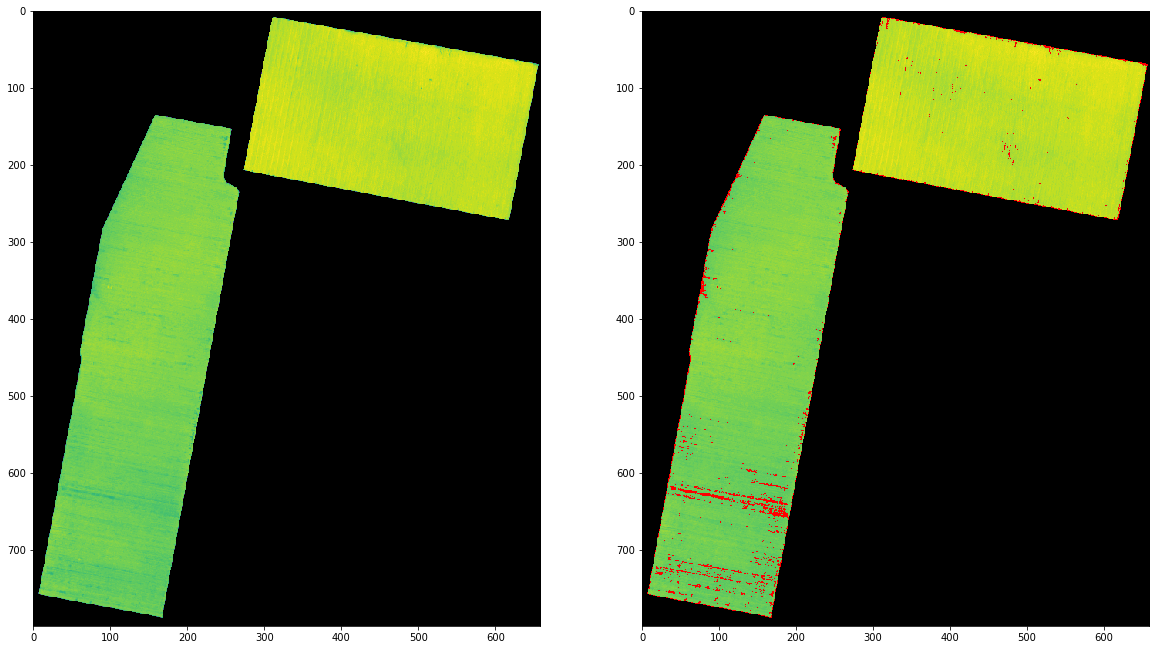

20180119T000000_TETRA-_PLN_ccci_gray.tif


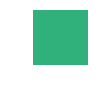

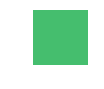

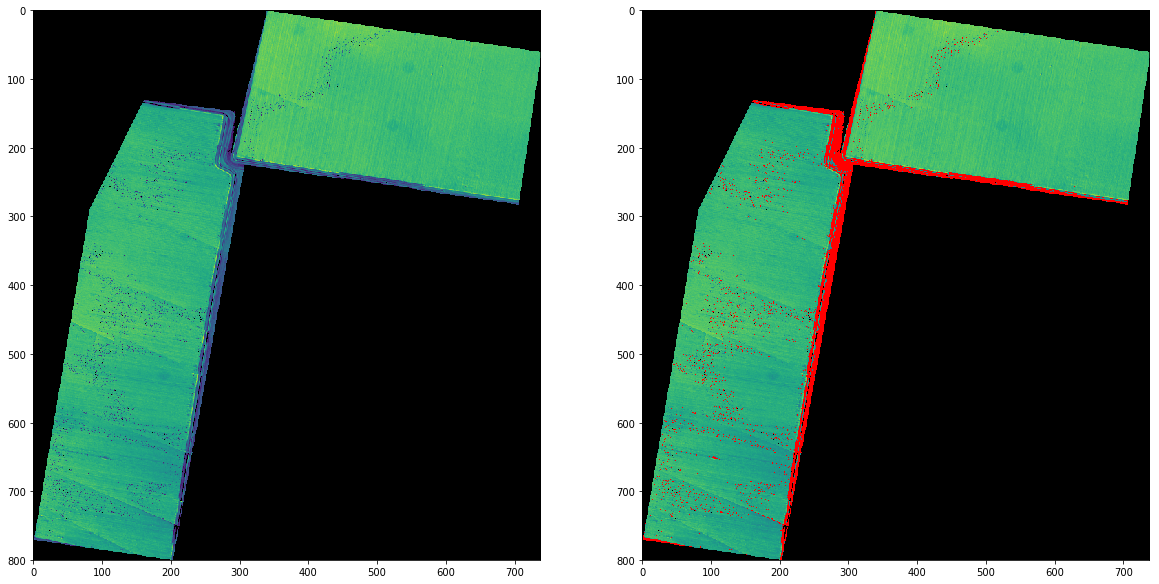

20180119T000000_TETRA-_PLN_msavi_gray.tif


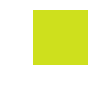

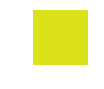

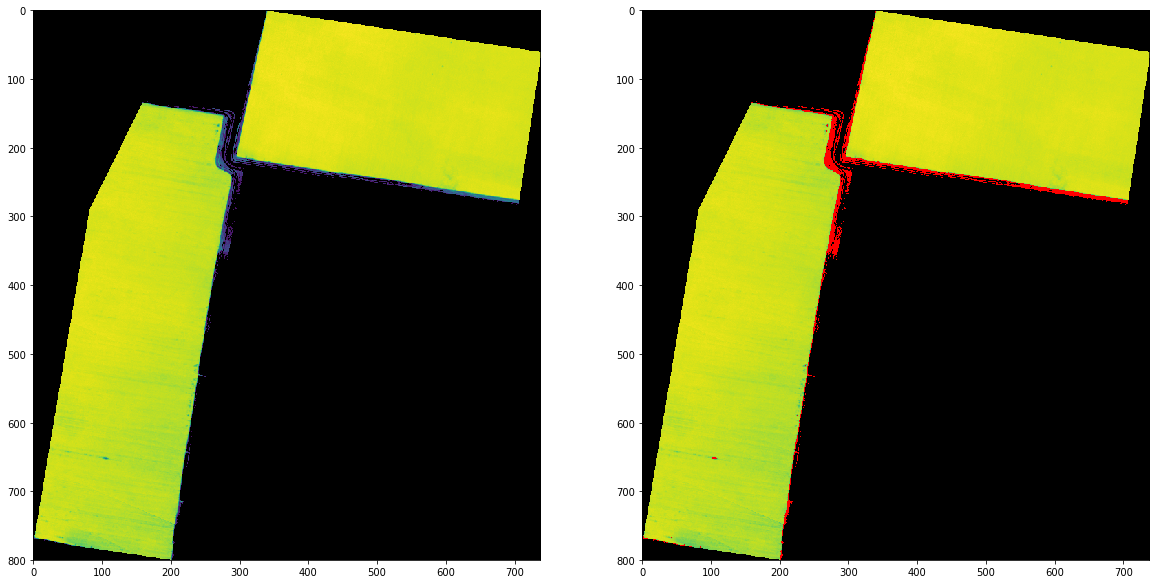

20180119T000000_TETRA-_PLN_ndre_gray.tif


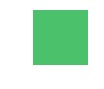

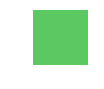

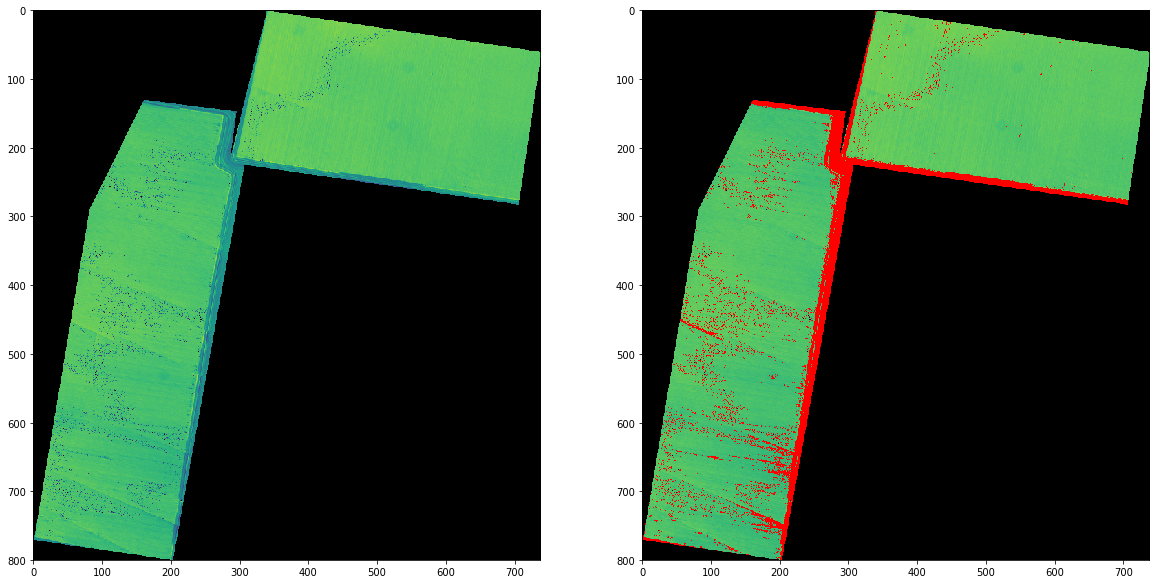

20180119T000000_TETRA-_PLN_ndvi_gray.tif


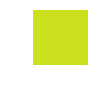

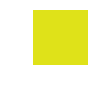

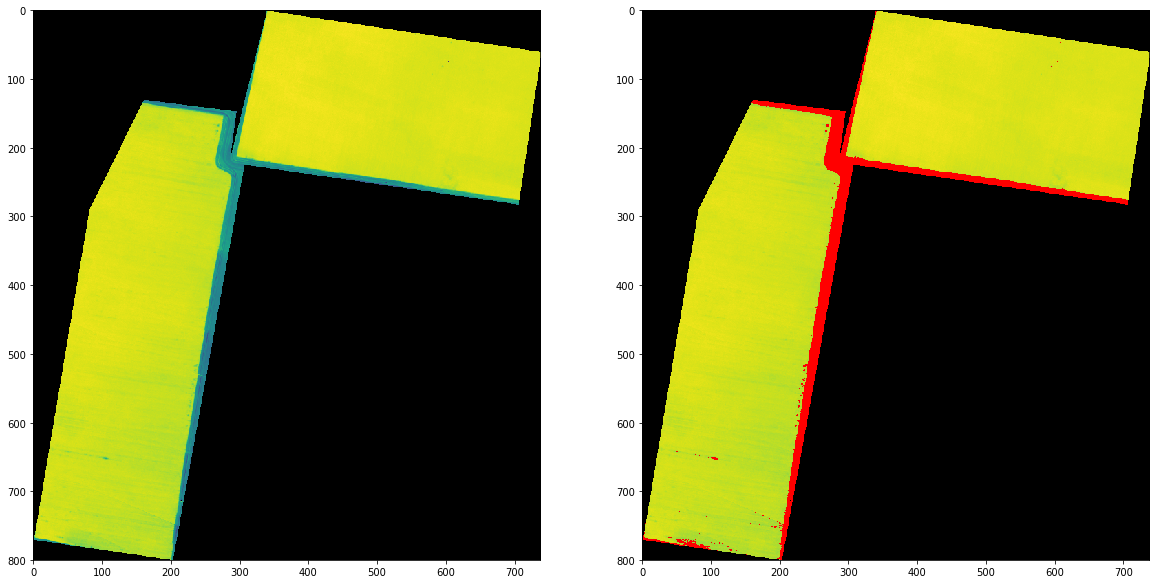

In [26]:
results = []
for item in im_list_tif:
    print(item)
    # Load Image as array
    im = Image.open(data_path + item)
    im_array = np.array(im)
    
    # Convert to RGB array
    img = convertToRGB(im_array)
    
    # Convert Purple Background to Black
    img = get_similar_bg(img, [68, 1, 84], 5)
    
    # Segment both fields into separate pictures
    img_1 = np.zeros(img.shape, dtype="uint8")
    img_2 = np.zeros(img.shape, dtype="uint8")
    img_1[:, :273, :] = img[:, :273, :]
    img_2[:, 273:, :] = img[:, 273:, :]
    
    # Get top K dominant_colours
    _, dom_colours_1 = get_dominant_colours(img_1, K)
    _, dom_colours_2 = get_dominant_colours(img_2, K)
    
    # Get reference colour for similarity test
    mean_colour_1 = dom_colours_1[np.argmax(np.sum(dom_colours_1, axis=1))]
    mean_colour_2 = dom_colours_2[np.argmax(np.sum(dom_colours_2, axis=1))]
    
    show_colour(mean_colour_1)
    show_colour(mean_colour_2)
    
    # Perform similarity test
    threshold_keys = list(image_thresholds.keys())
    label = threshold_keys[[key in item for key in threshold_keys].index(True)]
    new_img_1 = get_similar(np.copy(img_1), mean_colour_1, image_thresholds[label][0])
    new_img_2 = get_similar(np.copy(img_2), mean_colour_2, image_thresholds[label][1])
    
    result = cv2.add(new_img_1, new_img_2)
    results.append(result)
    
    fig, ax = plt.subplots(1,2, figsize=(20,20))
    ax[0].imshow(img)
    ax[1].imshow(result)
    plt.show()

In [27]:
export_results("Results/", results)